In [366]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Dataset
### Downloaded from: http://www.football-data.co.uk/englandm.php

In [367]:
epl1617 = "./EPL16:17.csv"
df1617 = pd.read_csv(epl1617)

epl1516 = "./EPL 15:16.csv"
df1516 = pd.read_csv(epl1516)

## List of all the teams

In [368]:
teamList = ['Arsenal', 'Bournemouth', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Southampton', 'Stoke', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham']
team_names = pd.DataFrame(teamList, columns=['Team_name'])
(team_names[team_names["Team_name"]  == "Liverpool"])

,Team_name
7,Liverpool


## Creating winner and loser column

In [369]:
def win(row):
    if (row["FTR"] == "A"):
        return row["AwayTeam"]
    elif (row["FTR"] == "H"):
        return row["HomeTeam"]
    elif (row["FTR"] == "D"):
        return "None"
    

def lose(row):
    if (row["FTR"] == "A"):
        return row["HomeTeam"]
    elif (row["FTR"]  == "H"):
        return row["AwayTeam"]
    elif (row["FTR"]  == "D"):
        return "None"

df1617["Winner"] = df1617.apply(win, axis=1) 
df1617["Loser"] = df1617.apply(lose, axis=1)

df1516["Winner"] = df1516.apply(win, axis=1) 
df1516["Loser"] = df1516.apply(lose, axis=1)

## 16/17 dataset feature setup

In [370]:
def TeamData(teamName):
    annual_data = df1617
    #num goals scored in wins and losses 
    gamesHome = annual_data[annual_data["HomeTeam"] == teamName]
    totalGoalsScored = gamesHome["FTHG"].sum()
    gamesAway = annual_data[annual_data["AwayTeam"] == teamName]
    totalGames = gamesHome.append(gamesAway)
    numGames = len(totalGames.index)
    #total goals scored
    totalGoalsScored += gamesAway["FTAG"].sum()
    #total goals allowed
    totalGoalsAllowed = gamesHome["FTAG"].sum()
    totalGoalsAllowed += gamesAway["FTHG"].sum()
    #discipline: total red cards, total yellow cards
    totalYellowCards = gamesHome["HY"].sum()
    totalYellowCards += gamesAway["AY"].sum()
    totalRedCards = gamesHome["HR"].sum()
    totalRedCards += gamesHome["AY"].sum() 
    #total fouls 
    totalFouls = gamesHome["HF"].sum()
    totalFouls += gamesAway["AF"].sum()
    #total corners
    totalCorners = gamesHome["HC"].sum()
    totalCorners += gamesAway["AC"].sum()
    #shots per game (spg) = total shots / total games
    totalShots = gamesHome["HS"].sum()
    #avgshots per game
    totalShots += gamesAway["AS"].sum()
    if numGames != 0:
        spg = totalShots / numGames
    # avg shots allowed per game
    totalShotsAgainst = gamesHome["AS"].sum()
    totalShotsAgainst += gamesAway["HS"].sum()
    if numGames != 0:
        sag = totalShotsAgainst / numGames
    #Games Won percentage = Games Won / (Games won + Games Lost)
    gamesWon = annual_data[annual_data["Winner"] == teamName]
    gamesLost = annual_data[annual_data["Loser"] == teamName]
    numGamesWon = len(gamesWon.index)
    numGamesLost = len(gamesLost.index)
    if numGames != 0:
        gamesWonPercentage = numGamesWon / numGames
     #Defense stats
        #Goalie Saves = Shots on Goal - Goal Scored
    #totalShotsonGoal = tsog
    tsog  = gamesHome["HST"].sum()
    tsog += gamesAway["AST"].sum()
    goalieSaves = tsog - totalGoalsAllowed
       #Saves Percentage = Goalie Saves / Shots on Goal
    if tsog != 0:
        savesPercentage = goalieSaves / tsog
        #Saves Ratio = shots on Goal / Goalie Saves
    if goalieSaves != 0:
        savesRatio = tsog / goalieSaves
    
    #offense stats
        #Scoring Percentage = (Scoring Attempts - Goals Scored) / Scorring Attempts
    if totalShots != 0 :
        scoringPercentage = (totalShots - totalGoalsScored) / totalShots
        #Scoring Ratio = Shots on Goal / Goalie Saves
    if tsog != 0:
        scoringRatio = tsog / totalGoalsScored
        
    if numGames == 0: #if team not in dataset
        gamesWon = 0 
        gamesLost = 0
        totalGoalsScored = 0
        totalGoalsAllowed = 0
        totalYellowCards = 0
        totalRedCards = 0
        totalFouls = 0
        totalCorners = 0
        spg = 0
        sag = 0
        gamesWonPercentage = 0
        goalieSaves = 0 
        savesPercentage = 0
        savesRatio= 0
        scoringPercentage = 0 
        scoringRatio = 0 

    return[totalYellowCards, totalRedCards, scoringPercentage, totalCorners, spg, gamesWonPercentage]

In [371]:
TeamData("Arsenal")

[67, 44, 0, 227, 14, 0]

## 16/ 17 Model training

### Setting up Dimensionality of training set

In [372]:
totalNumGames = 0 
totalNumGames += len(df1617.index)
numFeatures = len(TeamData("Arsenal"))# to find dimensionality
xTrain1 = np.zeros((totalNumGames, numFeatures))
yTrain1 = np.zeros((totalNumGames))

### Importing team list 

In [373]:
from collections import defaultdict
annualDictionary = defaultdict(list)
for team in teamList:
    team_vector = TeamData(team)
    annualDictionary[team] = team_vector

### loading dataset according to dimensionality

In [374]:
team_vectors = annualDictionary
annual = df1617
numGamesInYear = len(annual.index)
xTrainAnnual = np.zeros((numGamesInYear, numFeatures))
yTrainAnnual = np.zeros((numGamesInYear))
counter = 0 

### Formulating of X-train and Y-train 
#### X-train = Difference between the features of 2 teams
#### Y-train = If home team wins, Y-train = 1
####                If Away team wins, Y-train = 0 

In [375]:
for index, row in annual.iterrows():
    h_team = row["HomeTeam"]
    h_vector = team_vectors[h_team]
    a_team = row["AwayTeam"]
    a_vector = team_vectors[a_team]
    diff = [a-b for a, b in zip(h_vector, a_vector)]
    if (counter % 2 == 0):
        if len(diff) != 0:
            xTrainAnnual[counter] = diff
        yTrainAnnual[counter] = 1
    else: 
        if len(diff)!=0:
            xTrainAnnual[counter] = [-p for p in diff]
        yTrainAnnual[counter] = 0
    counter += 1

### Making of training set after calculations

In [376]:
indexCounter = 0 
xTrain1[indexCounter:numGamesInYear+indexCounter] = xTrainAnnual
yTrain1[indexCounter:numGamesInYear+indexCounter] = yTrainAnnual
indexCounter += numGamesInYear

### 15/16 is added to improve trainning accuracy

### 15/16 dataset feature selection 

In [377]:
def TeamData2(teamName):
    annual_data = df1516
    #num goals scored in wins and losses 
    gamesHome = annual_data[annual_data["HomeTeam"] == teamName]
    totalGoalsScored = gamesHome["FTHG"].sum()
    gamesAway = annual_data[annual_data["AwayTeam"] == teamName]
    totalGames = gamesHome.append(gamesAway)
    numGames = len(totalGames.index)
    #total goals scored
    totalGoalsScored += gamesAway["FTAG"].sum()
    #total goals allowed
    totalGoalsAllowed = gamesHome["FTAG"].sum()
    totalGoalsAllowed += gamesAway["FTHG"].sum()
    #discipline: total red cards, total yellow cards
    totalYellowCards = gamesHome["HY"].sum()
    totalYellowCards -= gamesAway["AY"].sum()
    totalRedCards = gamesHome["HR"].sum()
    totalRedCards -= gamesHome["AY"].sum() 
    #total fouls 
    totalFouls = gamesHome["HF"].sum()
    totalFouls += gamesAway["AF"].sum()
    #total corners
    totalCorners = gamesHome["HC"].sum()
    totalCorners += gamesAway["AC"].sum()
    #shots per game (spg) = total shots / total games
    totalShots = gamesHome["HS"].sum()
    #avgshots per game
    totalShots += gamesAway["AS"].sum()
    if numGames != 0:
        spg = totalShots / numGames
    # avg shots allowed per game
    totalShotsAgainst = gamesHome["AS"].sum()
    totalShotsAgainst += gamesAway["HS"].sum()
    if numGames != 0:
        sag = totalShotsAgainst / numGames
    #Games Won percentage = Games Won / (Games won + Games Lost)
    gamesWon = annual_data[annual_data["Winner"] == teamName]
    gamesLost = annual_data[annual_data["Loser"] == teamName]
    numGamesWon = len(gamesWon.index)
    numGamesLost = len(gamesLost.index)
    if numGames != 0:
        gamesWonPercentage = numGamesWon / numGames
     #Defense stats
        #Goalie Saves = Shots on Goal - Goal Scored
    #totalShotsonGoal = tsog
    tsog  = gamesHome["HST"].sum()
    tsog += gamesAway["AST"].sum()
    goalieSaves = tsog - totalGoalsAllowed
       #Saves Percentage = Goalie Saves / Shots on Goal
    if tsog != 0:
        savesPercentage = goalieSaves / tsog
        #Saves Ratio = shots on Goal / Goalie Saves
    if goalieSaves != 0:
        savesRatio = tsog / goalieSaves
    
    #offense stats
        #Scoring Percentage = (Scoring Attempts - Goals Scored) / Scorring Attempts
    if totalShots != 0 :
        scoringPercentage = (totalShots - totalGoalsScored) / totalShots
        #Scoring Ratio = Shots on Goal / Goalie Saves
    if tsog != 0:
        scoringRatio = tsog / totalGoalsScored
        
    if numGames == 0: #if team not in dataset
        gamesWon = 0 
        gamesLost = 0
        totalGoalsScored
        totalGoalsAllowed = 0
        totalYellowCards = 0
        totalRedCards = 0
        totalFouls = 0
        totalCorners = 0
        spg = 0
        sag = 0
        gamesWonPercentage = 0
        goalieSaves = 0 
        savesPercentage = 0
        savesRatio= 0
        scoringPercentage = 0 
        scoringRatio = 0

    return[totalYellowCards, totalRedCards, scoringPercentage, totalCorners, spg, gamesWonPercentage]

In [378]:
totalNumGames = 0 
totalNumGames += len(df1516.index)
numFeatures = len(TeamData2("Arsenal"))# to find dimensionality
xTrain2 = np.zeros((totalNumGames, numFeatures))
yTrain2 = np.zeros((totalNumGames))

from collections import defaultdict
annualDictionary = defaultdict(list)
for team in teamList:
    team_vector = TeamData2(team)
    annualDictionary[team] = team_vector

team_vectors = annualDictionary
annual = df1516
numGamesInYear = len(annual.index)
xTrainAnnual = np.zeros((numGamesInYear, numFeatures))
yTrainAnnual = np.zeros((numGamesInYear))
counter = 0 

for index, row in annual.iterrows():
    h_team = row["HomeTeam"]
    h_vector = team_vectors[h_team]
    a_team = row["AwayTeam"]
    a_vector = team_vectors[a_team]
    diff = [a-b for a, b in zip(h_vector, a_vector)]
    if (counter % 2 == 0):
        if len(diff) != 0:
            xTrainAnnual[counter] = diff
        yTrainAnnual[counter] = 1
    else: 
        if len(diff)!=0:
            xTrainAnnual[counter] = [-p for p in diff]
        yTrainAnnual[counter] = 0
    counter += 1

indexCounter = 0 
xTrain2[indexCounter:numGamesInYear+indexCounter] = xTrainAnnual
yTrain2[indexCounter:numGamesInYear+indexCounter] = yTrainAnnual
indexCounter += numGamesInYear

In [379]:
### Combining the training sets of 16/17 and 15/16

In [380]:
xtrainfin = np.concatenate([xTrain2,xTrain1], axis=0)
ytrainfin = np.concatenate([yTrain2,yTrain1], axis=0)

In [381]:
ytrainfin.shape

(760,)

### Train test split

In [382]:
xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)

### Bayesian Linear regression

In [383]:
xTrain.shape

(570, 6)

In [384]:
xTraindf = pd.DataFrame(xTrain, columns=['totalYellowCards', 'totalRedCards', 'scoringPercentage', 'totalCorners', 'spg', 'gamesWonPercentage'])

In [385]:
bylr = xTraindf.copy()
bylr['yTrain'] = yTrain

In [386]:
import pymc3 as pm
with pm.Model() as reg:
    pm.glm.GLM.from_formula('yTrain ~ totalYellowCards + totalRedCards + scoringPercentage + totalCorners + spg + gamesWonPercentage', bylr)
    trace = pm.sample(1000, cores=2, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, gamesWonPercentage, spg, totalCorners, scoringPercentage, totalRedCards, totalYellowCards, Intercept]
100%|██████████| 2000/2000 [00:17<00:00, 111.95it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2bfefbd0>,
      dtype=object)

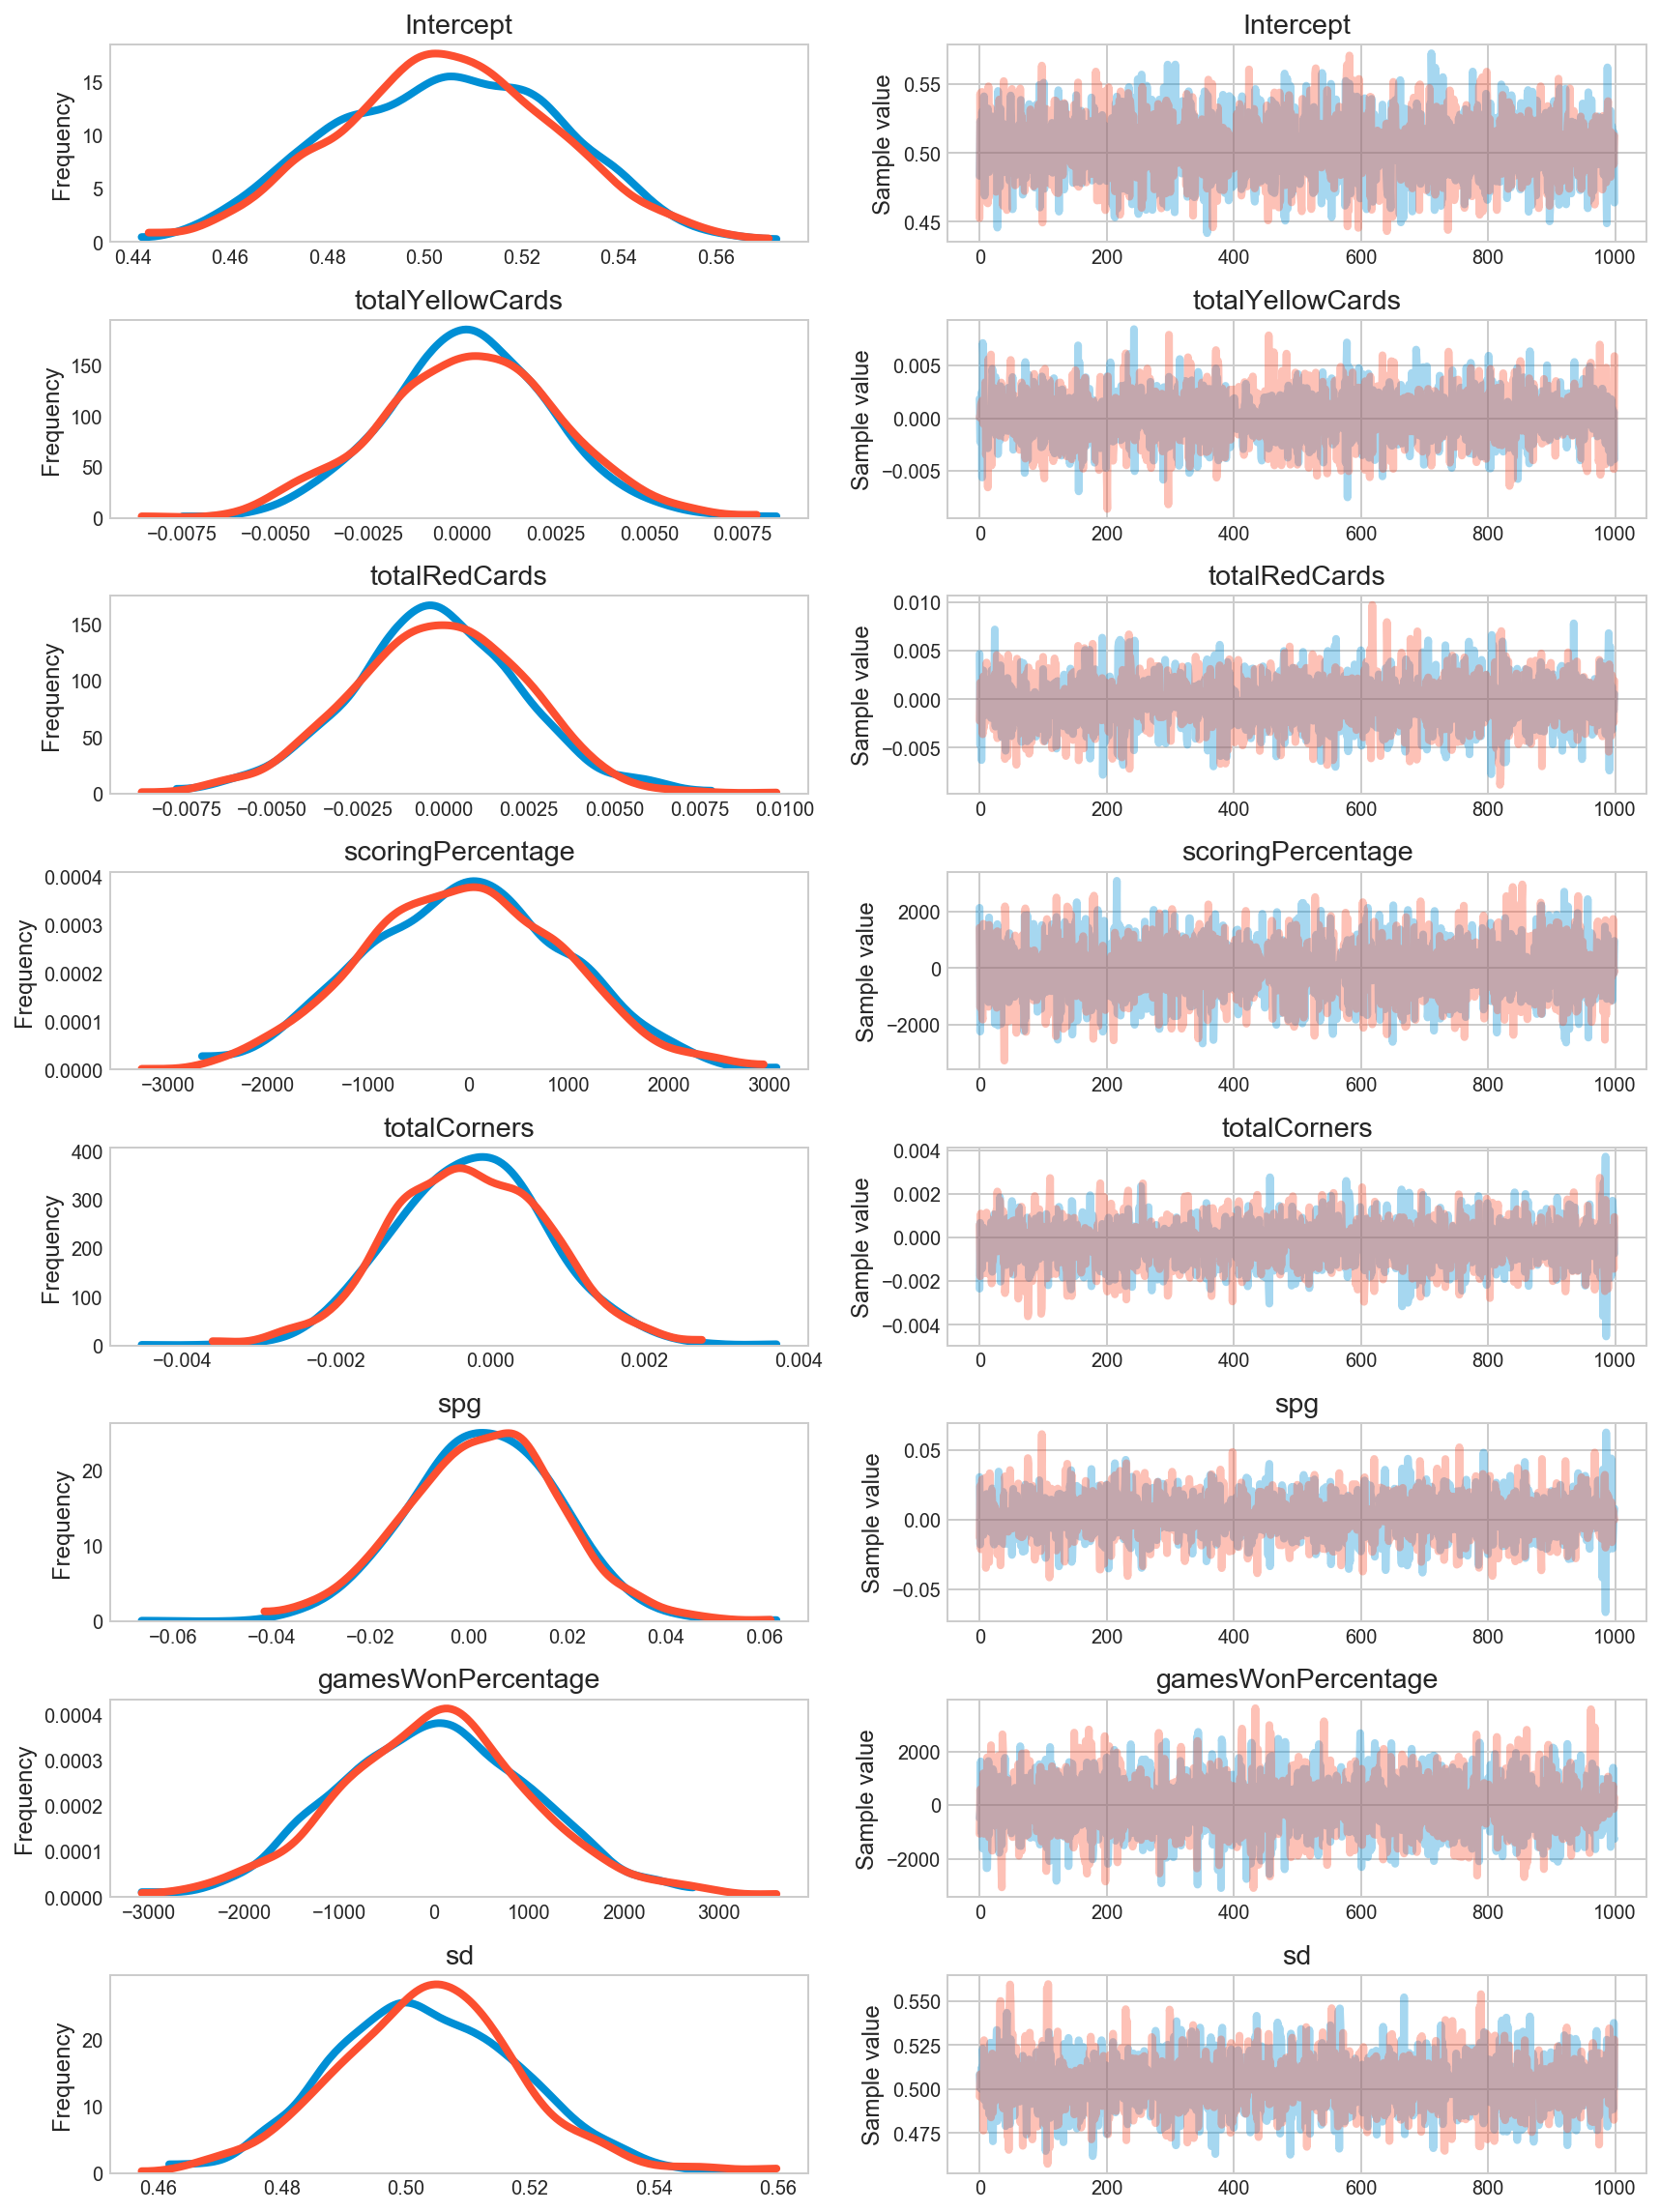

In [387]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c238fe810>,
      dtype=object)

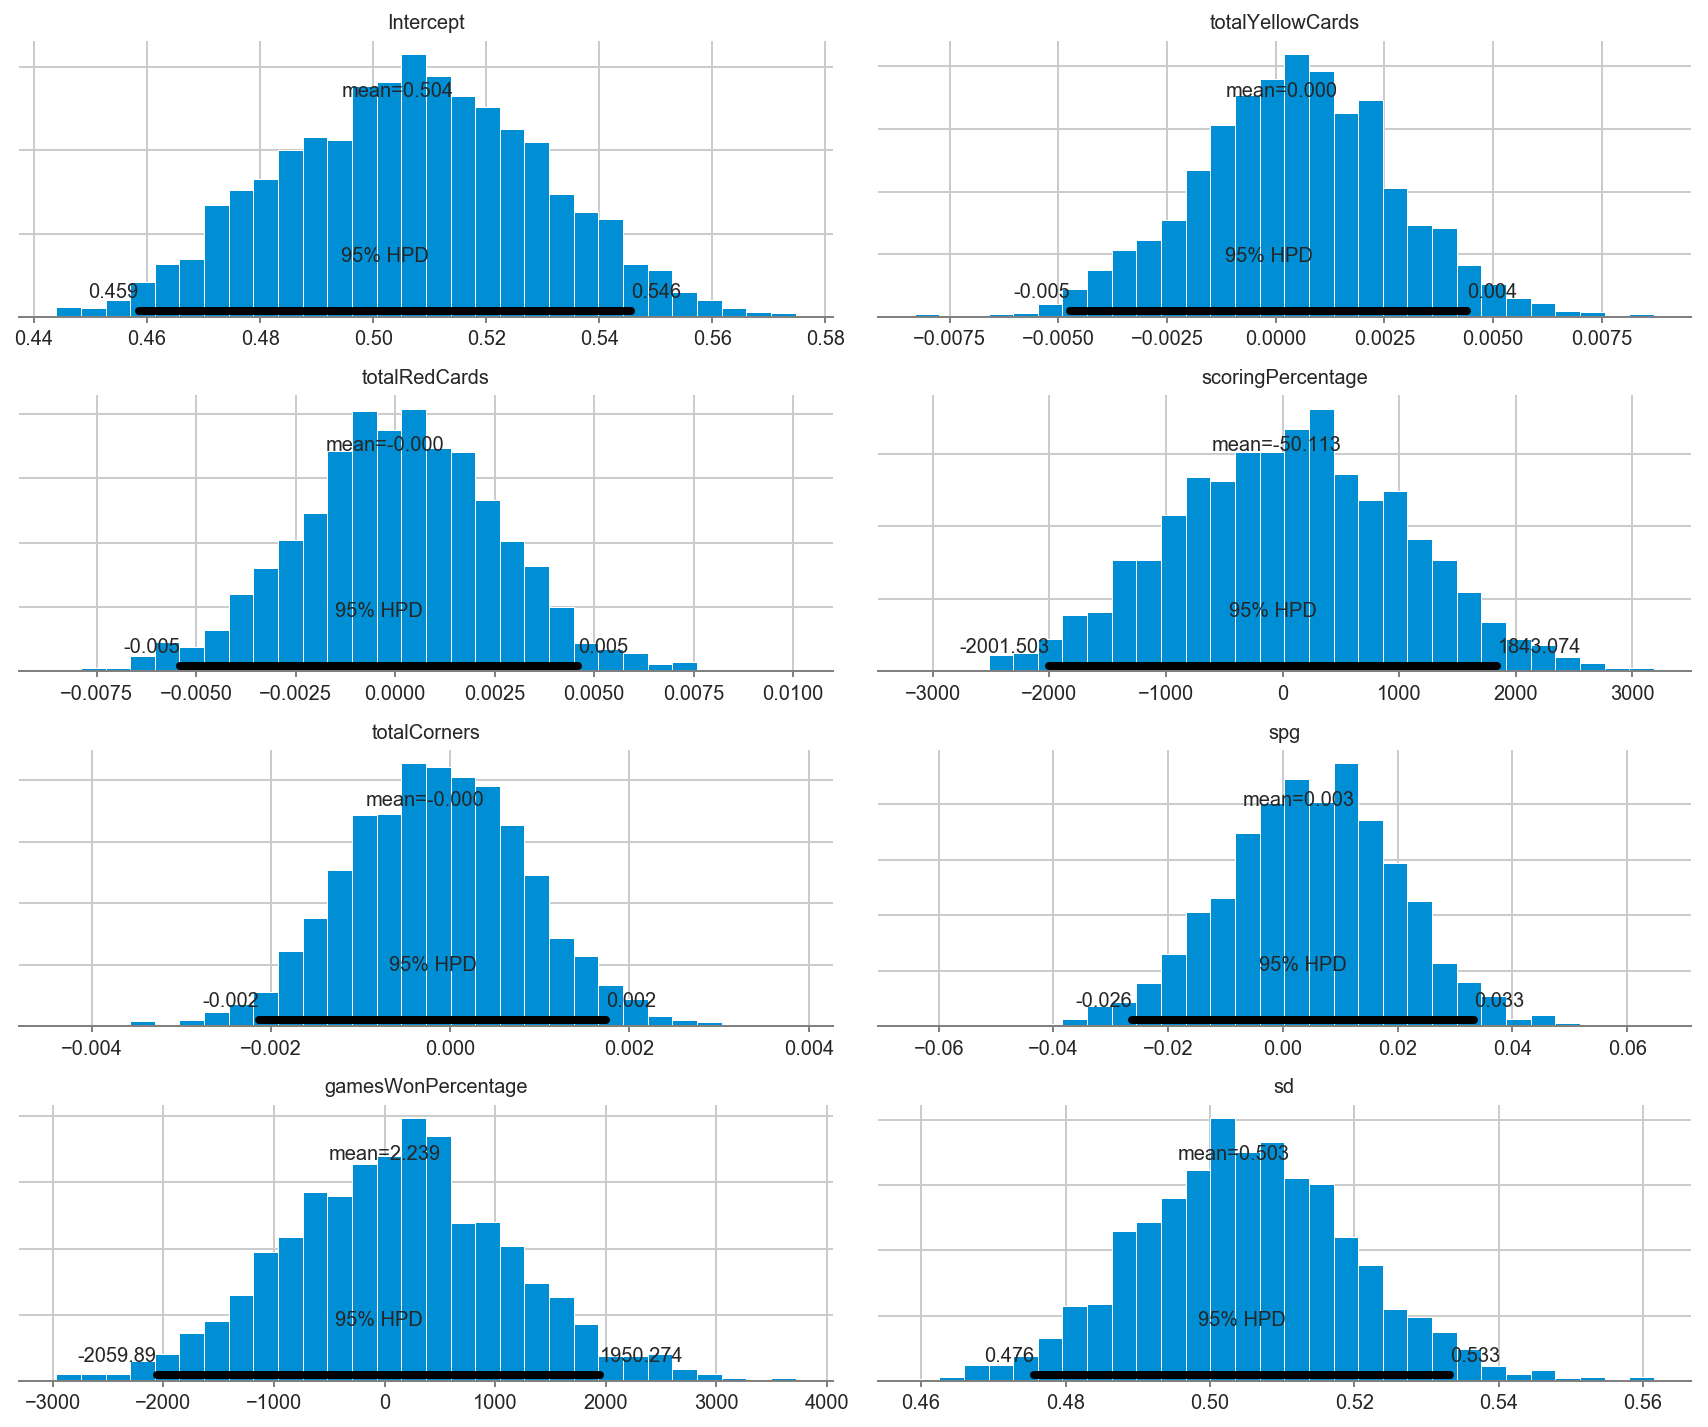

In [388]:
pm.plot_posterior(trace)

In [389]:
ppc = pm.sample_ppc(trace, model=reg, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 900.37it/s]


In [390]:
# result = []
# for i in ppc['y']:
#     result.append(i.mean())
# # ppc['y'][0].mean()
# BLavgpredict = sum(result)/len(result)
# print BLavgpredict

In [391]:
model_formula = 'Featuressum = '
for variable in trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Featuressum =  0.50 * Intercept + 0.00 * totalYellowCards + -0.00 * totalRedCards + -50.11 * scoringPercentage + -0.00 * totalCorners + 0.00 * spg + 2.24 * gamesWonPercentage + -0.69 * sd_log__ + 0.50 * sd'

In [392]:
var_dict = {}
for variable in trace.varnames:
    var_dict[variable] = trace[variable]
var_weights = pd.DataFrame(var_dict)
var_means = var_weights.mean(axis=0)
var_means

Intercept              0.504392
gamesWonPercentage     2.239020
scoringPercentage    -50.112977
sd                     0.503320
sd_log__              -0.686969
spg                    0.002806
totalCorners          -0.000285
totalRedCards         -0.000248
totalYellowCards       0.000146
dtype: float64

In [393]:
X_testt = pd.DataFrame(X_test, columns=['totalYellowCards', 'totalRedCards', 'scoringPercentage', 'totalCorners', 'spg', 'gamesWonPercentage'])

In [394]:
X_testt['Intercept'] = 1

In [395]:
names = X_testt.columns[1:]
X_testt = X_testt.loc[:, names]
var_means = var_means[names]

In [396]:
var_means

totalRedCards         -0.000248
scoringPercentage    -50.112977
totalCorners          -0.000285
spg                    0.002806
gamesWonPercentage     2.239020
Intercept              0.504392
dtype: float64

In [397]:
ppc = pm.sample_ppc(trace, model=reg, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 855.45it/s]


In [398]:
result = []
for i in ppc['y']:
    result.append(i.mean())
# ppc['y'][0].mean()
BLavgpredict = sum(result)/len(result)
print BLavgpredict

0.5037130659390507


## Result Using other Standard Machine Learning Models

In [399]:
def evaluate(xTrain, X_test, yTrain, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'AdaBoostRegressor', 'ElasticNet Regression',
                       'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = AdaBoostRegressor()
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(xTrain, yTrain)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(yTrain)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [400]:
results = evaluate(xTrain, X_test, yTrain, y_test)

/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Comparing of results of the various models

In [401]:
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Model  MAE: 0.5004
Model RMSE: 0.5005


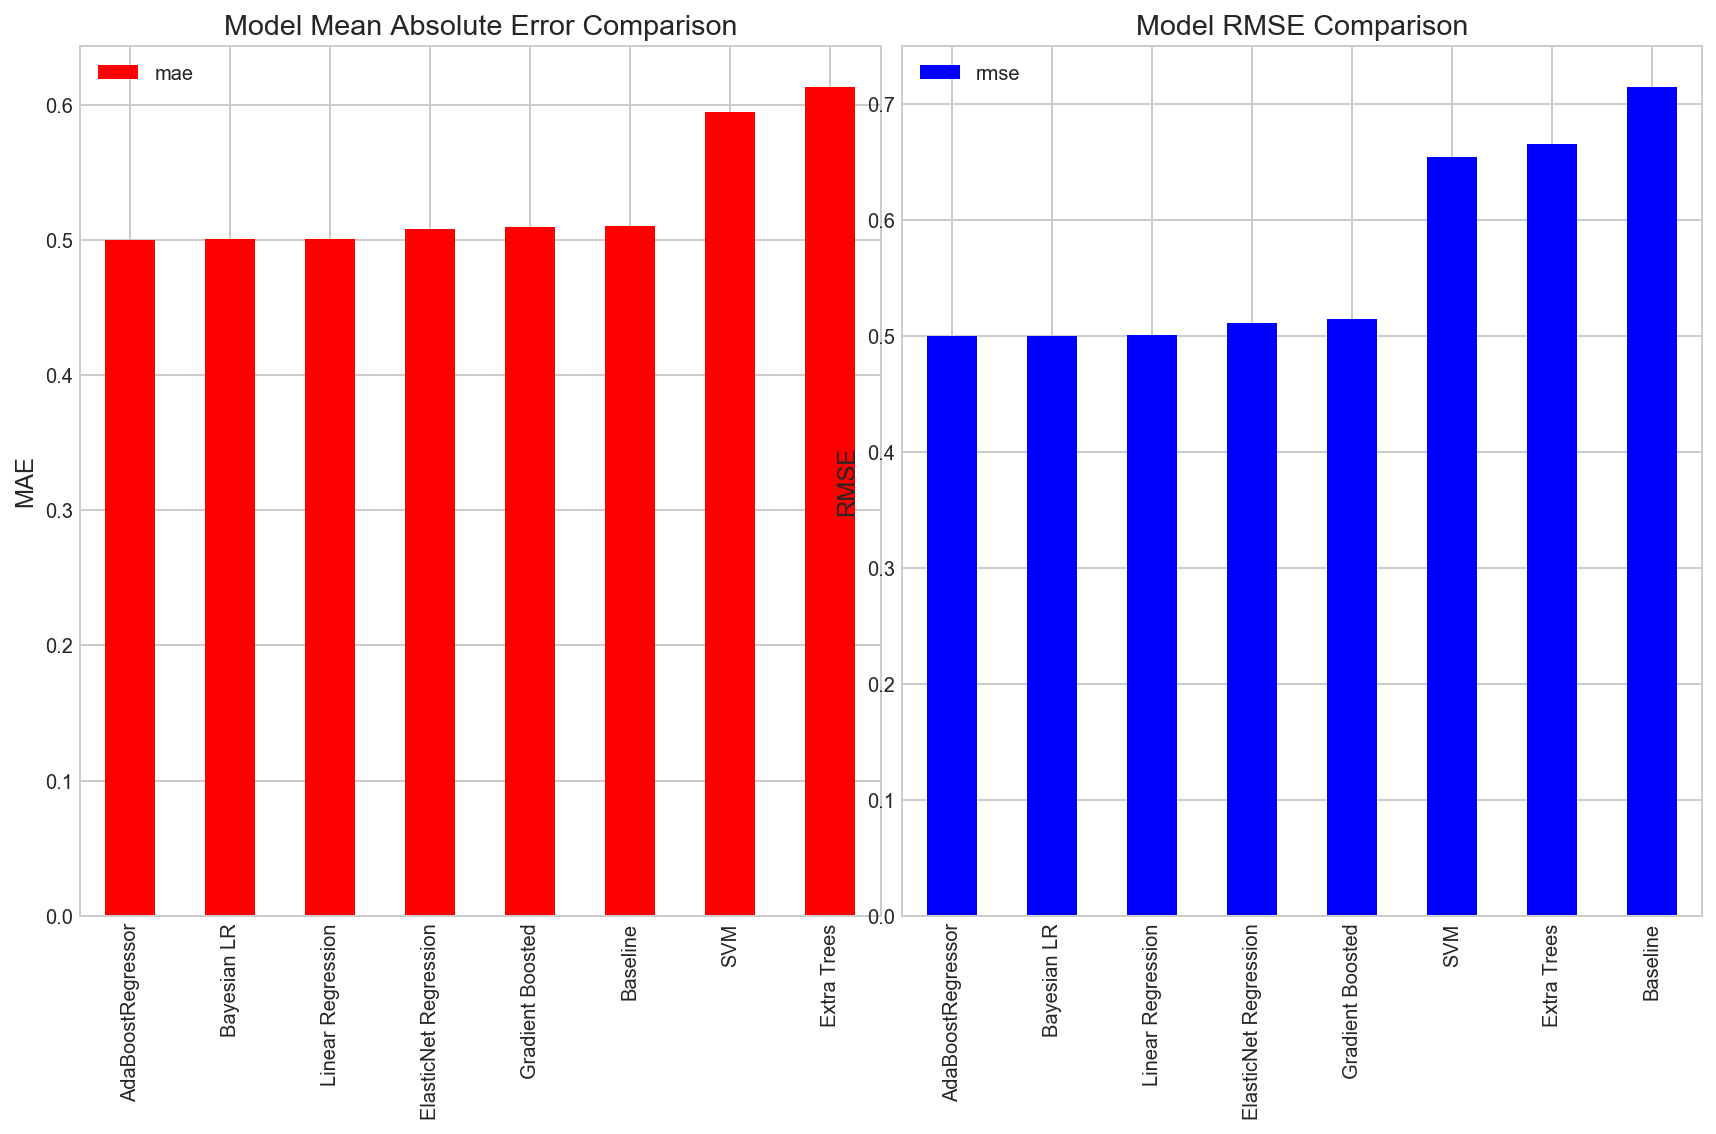

In [402]:
all_model_results = evaluate_trace(trace, xTrain, X_testt, yTrain, y_test, results)

## Results

In [403]:
results

,mae,rmse
Linear Regression,0.500489,0.500585
AdaBoostRegressor,0.500074,0.500086
ElasticNet Regression,0.508289,0.511595
Extra Trees,0.612697,0.665779
SVM,0.594775,0.654198
Gradient Boosted,0.509487,0.514519
Baseline,0.510526,0.714511
Bayesian LR,0.50041,0.500486


## Game Prediction

### Download of season 17/18 schedule

In [404]:
epl1718 = "./17:18 schedule.csv"
df1718 = pd.read_csv(epl1718)
test = df1718
test["Game_ID"].tail()
test = test.drop(test.index[-1])
test["Game_ID"] = test["Game_ID"].astype(int)
test.head()

,Game_ID,Date,HomeTeam,AwayTeam
0,1,11/8/17,Arsenal,Leicester
1,2,12/8/17,Brighton,Man City
2,3,12/8/17,Chelsea,Burnley
3,4,12/8/17,Crystal Palace,Huddersfield
4,5,12/8/17,Everton,Stoke


### Prediction of each home game

In [409]:
def createGamePred(team1_vector, team2_vector, xTrain, yTrain):
    xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)
    AB = AdaBoostRegressor()
    AB.fit(xTrain, yTrain)
    diff = np.array([a - b for a, b in zip(team1_vector, team2_vector)])
    predictions = AB.predict(diff.reshape(1,-1))
    return predictions

In [410]:
def formulatePredictions():
    probs = [[0 for x in range(2)] for x in range(len(test.index))]
    for index, row in test.iterrows():
        game_ID = row["Game_ID"]
        team1_Name = row["HomeTeam"]
        team2_Name = row["AwayTeam"]
        team1_vector = TeamData(team1_Name)
        team2_vector = TeamData(team2_Name)
        prediction = createGamePred(team1_vector, team2_vector, xTrain, yTrain)
        probs[index][0] = game_ID
        probs[index][1] = prediction
    probs = pd.np.array(probs)
    return probs

### Prediction of each Away game

In [407]:
# def createGamePred(team1_vector, team2_vector, xTrain, yTrain):
#     xTrain, X_test, yTrain, y_test = train_test_split(xtrainfin, ytrainfin)
#     AB = AdaBoostRegressor()
#     AB.fit(xTrain, yTrain)
#     diff = np.array([a - b for a, b in zip(team1_vector, team2_vector)])
#     predictions = AB.predict(diff.reshape(1,-1))
#     return predictions

## Creation of dataframe for game list

In [411]:
predictdf=pd.DataFrame(formulatePredictions(), columns=[["Game_ID","Prediction"]])
pf1 = predictdf.drop(['Game_ID'], axis = 1)
predictable = pd.concat([test, pf1], axis=1)
predictable.columns
ptdf = predictable.drop(predictable.index[-1])

### Taking out matches involving Brighton, Huddersfield and Newcastlle

In [412]:
ptdf2 = ptdf[ptdf.HomeTeam.str.contains("Brighton") == False]
ptdf3 = ptdf2[ptdf2.AwayTeam.str.contains("Brighton") == False]
ptdf4 = ptdf3[ptdf3.HomeTeam.str.contains("Huddersfield") == False]
ptdf5 = ptdf4[ptdf4.AwayTeam.str.contains("Huddersfield") == False]
ptdf6 = ptdf5[ptdf5.HomeTeam.str.contains("Newcastle") == False]
ptdf7 = ptdf6[ptdf6.AwayTeam.str.contains("Newcastle") == False]

In [413]:
ptdf7.columns.values[4] = "HTwinPredict"

In [414]:
ptdf7.head()

,Game_ID,Date,HomeTeam,AwayTeam,HTwinPredict
0,1,11/8/17,Arsenal,Leicester,0.308824
2,3,12/8/17,Chelsea,Burnley,0.487871
4,5,12/8/17,Everton,Stoke,0.485014
5,6,12/8/17,Southampton,Swansea,0.644928
6,7,12/8/17,Watford,Liverpool,0.000000


In [415]:
ptdf7.columns
ptdf7["ATwinPredict"] = 1 - ptdf7.iloc[:,4]

Index([u'Game_ID', u'Date', u'HomeTeam', u'AwayTeam', u'HTwinPredict'], dtype='object')

In [434]:
ptdf7.head(50)

,Game_ID,Date,HomeTeam,AwayTeam,HTwinPredict,ATwinPredict,Winner,Loser
0,1,11/8/17,Arsenal,Leicester,0.308824,0.691176,Leicester,Arsenal
2,3,12/8/17,Chelsea,Burnley,0.487871,0.512129,Burnley,Chelsea
4,5,12/8/17,Everton,Stoke,0.485014,0.514986,Stoke,Everton
5,6,12/8/17,Southampton,Swansea,0.644928,0.355072,Southampton,Swansea
6,7,12/8/17,Watford,Liverpool,0.000000,1.000000,Liverpool,Watford
7,8,12/8/17,West Brom,Bournemouth,0.491094,0.508906,Bournemouth,West Brom
8,9,13/8/17,Man United,West Ham,0.704762,0.295238,Man United,West Ham
10,11,19/8/17,Bournemouth,Watford,0.000000,1.000000,Watford,Bournemouth
11,12,19/8/17,Burnley,West Brom,0.498516,0.501484,West Brom,Burnley
13,14,19/8/17,Liverpool,Crystal Palace,0.880000,0.120000,Liverpool,Crystal Palace


In [ ]:
# dfAF3 = dfAF2.reset_index(drop=True)

In [ ]:
# ptdf7.set_index("Game_ID").head()
# ptdf9 = ptdf7.reset_index(drop=True)

In [ ]:
# ptdf9["AT win Predict"] = dfAF3.loc[:, 4]

In [422]:
def win(row):
    if (row["HTwinPredict"] > row["ATwinPredict"]):
        return row["HomeTeam"]
    elif (row["ATwinPredict"] > row["HTwinPredict"]):
        return row["AwayTeam"]
    elif (row["ATwinPredict"] == row["HTwinPredict"]):
        return "DRAW"
    

def lose(row):
    if (row["HTwinPredict"] < row["ATwinPredict"]):
        return row["HomeTeam"]
    elif (row["ATwinPredict"] < row["HTwinPredict"]):
        return row["AwayTeam"]
    elif (row["ATwinPredict"] == row["HTwinPredict"]):
        return "DRAW"

ptdf7["Winner"] = ptdf7.apply(win, axis=1) 
ptdf7["Loser"] = ptdf7.apply(lose, axis=1)

/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [423]:
ptdf7.head()

,Game_ID,Date,HomeTeam,AwayTeam,HTwinPredict,ATwinPredict,Winner,Loser
0,1,11/8/17,Arsenal,Leicester,0.308824,0.691176,Leicester,Arsenal
2,3,12/8/17,Chelsea,Burnley,0.487871,0.512129,Burnley,Chelsea
4,5,12/8/17,Everton,Stoke,0.485014,0.514986,Stoke,Everton
5,6,12/8/17,Southampton,Swansea,0.644928,0.355072,Southampton,Swansea
6,7,12/8/17,Watford,Liverpool,0.000000,1.000000,Liverpool,Watford


In [424]:
ptdf7.columns

Index([u'Game_ID', u'Date', u'HomeTeam', u'AwayTeam', u'HTwinPredict',
       u'ATwinPredict', u'Winner', u'Loser'],
      dtype='object')

In [425]:
ptdf7["Winner"].value_counts()

Stoke             21
Liverpool         20
Southampton       18
Watford           18
Arsenal           17
Tottenham         16
West Brom         16
Man City          15
Burnley           15
Bournemouth       15
Chelsea           15
Crystal Palace    14
Swansea           14
Leicester         13
Everton           12
West Ham          11
Man United        11
DRAW              10
Name: Winner, dtype: int64

In [426]:
ptdf7["Loser"].value_counts()

West Ham          19
Everton           19
Man United        18
Crystal Palace    17
Leicester         17
Swansea           16
West Brom         16
Burnley           15
Man City          15
Chelsea           15
Bournemouth       15
Arsenal           15
Tottenham         14
Watford           14
Southampton       13
Liverpool         12
Stoke             11
DRAW              10
Name: Loser, dtype: int64

In [427]:
ptdf7.shape

(271, 8)